In [1]:
%matplotlib inline

import os
import datetime
import functools

import pandas as pd

PROJECT_ID = 'scripting-148608'

def get_credentials(scopes, secrets='~/client_secrets.json', storage='~/storage.json'):
    from oauth2client import file, client, tools
    store = file.Storage(os.path.expanduser(storage))
    creds = store.get()
    if creds is None or creds.invalid:
        flow = client.flow_from_clientsecrets(os.path.expanduser(secrets), scopes)
        creds = tools.run_flow(flow, store, tools.argparser.parse_args([]))
    return creds

class GbqConnector(pd.io.gbq.GbqConnector):

    def get_user_account_credentials(self):
        return get_credentials(self.scope)

pd.io.gbq.GbqConnector = GbqConnector  # monkey patch

read_gbq = functools.partial(pd.io.gbq.read_gbq, project_id=PROJECT_ID)

In [2]:
RESULT, START, END = 'pypi-graphviz.csv', '20160601', datetime.datetime.now().strftime('%Y%m%d')

query = '''SELECT
  YEAR(timestamp) AS year, MONTH(timestamp) AS month,
  REGEXP_EXTRACT(details.python, r'^([^\.]+\.[^\.]+)') AS python,
  COUNT(*) AS downloads
FROM TABLE_DATE_RANGE([the-psf:pypi.downloads], TIMESTAMP('%s'), TIMESTAMP('%s'))
WHERE file.project = 'graphviz'
GROUP BY year, month, python
ORDER BY year DESC, month DESC, downloads DESC''' % (START, END)

if not os.path.exists(RESULT):
    df = read_gbq(query)
    df.to_csv(RESULT, index=False, encoding='utf-8')

df = pd.read_csv(RESULT, encoding='utf-8')
df.head()

,year,month,python,downloads
0,2017,2,2.7,21579
1,2017,2,3.5,7312
2,2017,2,3.4,5247
3,2017,2,NaN,4249
4,2017,2,3.6,1899


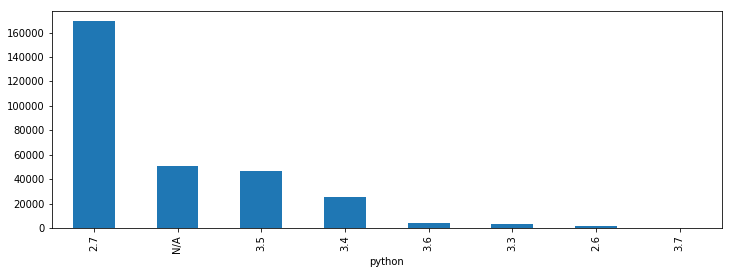

In [3]:
df.fillna('N/A').groupby('python')['downloads'].sum()\
    .sort_values(ascending=False)[:8].plot.bar(figsize=(12, 4));

In [4]:
df.fillna('N/A').groupby('python')['downloads'].sum()\
    .sort_values(ascending=False).to_frame()\
    .apply(lambda x: x / x.sum()).style.format('{:.2%}').set_uuid('4')

In [5]:
RESULT, START, END = 'pypi-graphviz-0702.csv', '20170201', '20170223'

query = '''SELECT
  EXTRACT(YEAR FROM timestamp) AS year, EXTRACT(MONTH FROM timestamp) AS month,
  country_code AS country,
  file.version AS version, file.type AS type,
  REGEXP_EXTRACT(details.python, r'^([^\.]+\.[^\.]+)') AS python,
  details.system.name AS system,
  COUNT(*) AS downloads
FROM `the-psf.pypi.downloads*`
WHERE _TABLE_SUFFIX BETWEEN '%s' AND '%s' AND file.project = 'graphviz'
GROUP BY year, month, country, version, type, python, system''' % (START, END)

if not os.path.exists(RESULT):
    ff = read_gbq(query, dialect='standard')
    ff.to_csv(RESULT, index=False, encoding='utf-8')

ff = pd.read_csv(RESULT, encoding='utf-8').fillna('N/A')
ff.head()

,year,month,country,version,type,python,system,downloads
0,2017,2,N/A,0.3.1,sdist,N/A,N/A,6
1,2017,2,N/A,0.4.2,bdist_wheel,N/A,N/A,6
2,2017,2,N/A,0.4.7,bdist_wheel,N/A,N/A,6
3,2017,2,N/A,0.5.2,sdist,N/A,N/A,18
4,2017,2,N/A,0.5.2,sdist,2.6,N/A,1


In [6]:
ff['downloads'].sum()

39164

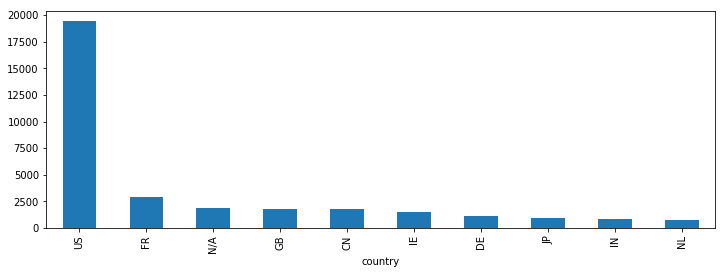

In [7]:
ff.groupby('country')['downloads'].sum().sort_values(ascending=False)[:10].plot.bar(figsize=(12, 4));

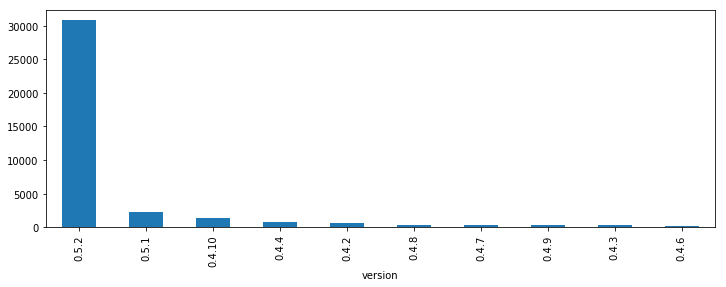

In [8]:
ff.groupby('version')['downloads'].sum().sort_values(ascending=False)[:10].plot.bar(figsize=(12, 4));

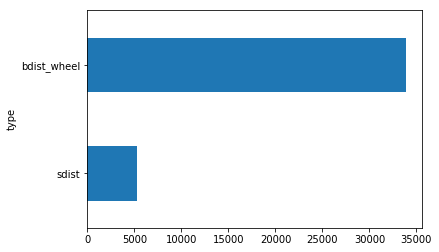

In [9]:
ff.groupby('type')['downloads'].sum().sort_values().plot.barh();

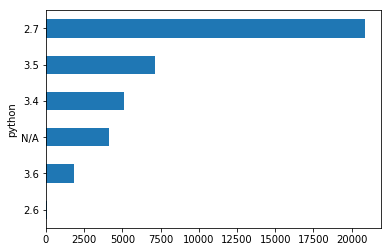

In [10]:
ff.groupby('python')['downloads'].sum().sort_values()[-6:].plot.barh();

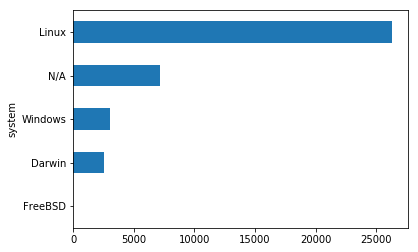

In [11]:
ff.groupby('system')['downloads'].sum().sort_values()[-5:].plot.barh();